# Predição de Consumo de Combustível

Criação de modelos de aprendizado supervisionado para predizer o consumo de combustível de carros.

## Imports

É importante notar que boa parte do programa foi encapsulado em outros arquivos que são importados nesta seção do código.

In [1]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split

import preprocessing as pre
import plots as pl
import spot_checking as sc

## Análise Exploratória dos Dados

Aqui foi realizado o carregamento dos dados originais de um arquivo _csv_.

In [2]:
original_df = pd.read_csv('data/car_data_original.csv')

Com esses dados, realizou-se a construção de diversos gráficos de distribuições e correlações para analisar o que é interessante de ser realizado em relação aos atributos preditores na etapa de pré-processamento. Primeiramente, construiu-se um _violin plot_ comparando o consumo médio de combustível por quantidade de instâncias.

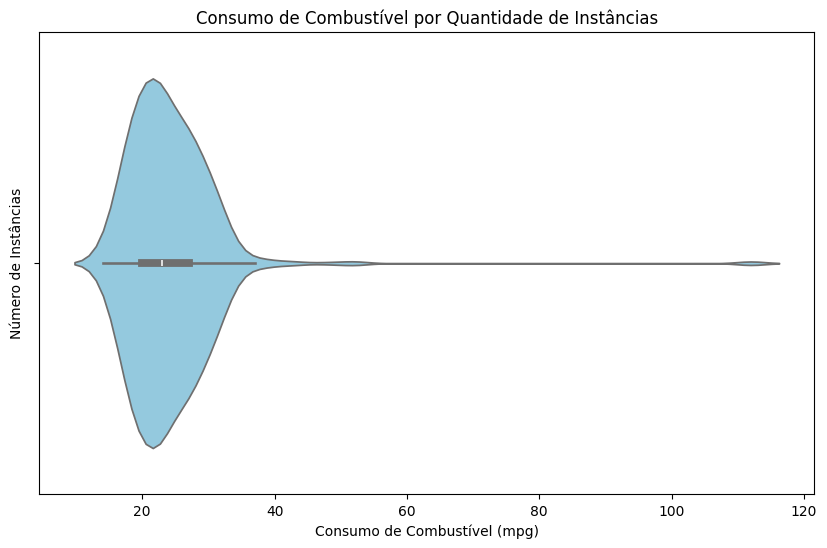

In [3]:
pl.plot_violinplot(original_df,
                  'combination_mpg',
                  'Consumo de Combustível por Quantidade de Instâncias',
                  'Consumo de Combustível (mpg)',
                  'pure_combination_mpg')

Nesse ponto, já se observa que há instâncias problemáticas, claramente _outliers_ que devem ser removidas do conjunto de dados. Ademais, a maior concentração dos veículos apresenta consumo médio entre 15 e 30mpg, algo que pode guiar bastante os modelos.

Após isso, analisou-se o atributo de classes de veículos para ter uma ideia da sua distribuição em um gráfico de setores.

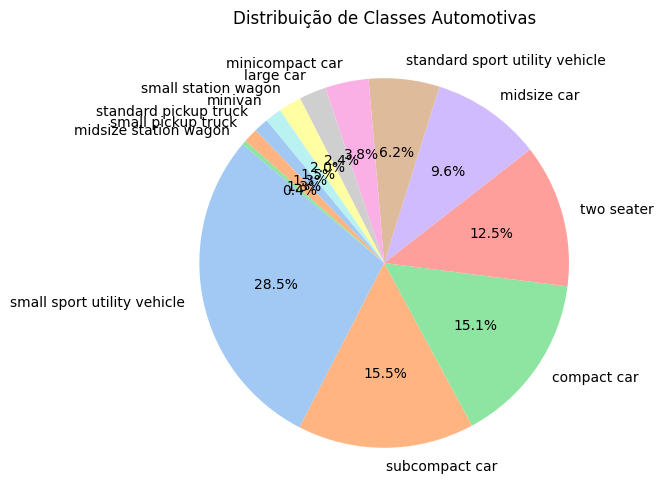

In [4]:
pl.plot_piechart(original_df,
                 'class',
                 'Distribuição de Classes Automotivas',
                 'pure_car_classes')

Com ele, é perceptível a necessidade de agrupar classes de veículos com muito poucos representantes, como _midsize station wagon_, por exemplo, em uma classe geral chamada _others_.

Por fim, analisou-se a Correlação de Pearson entre os atributos numéricos através do _heatmap_ abaixo:

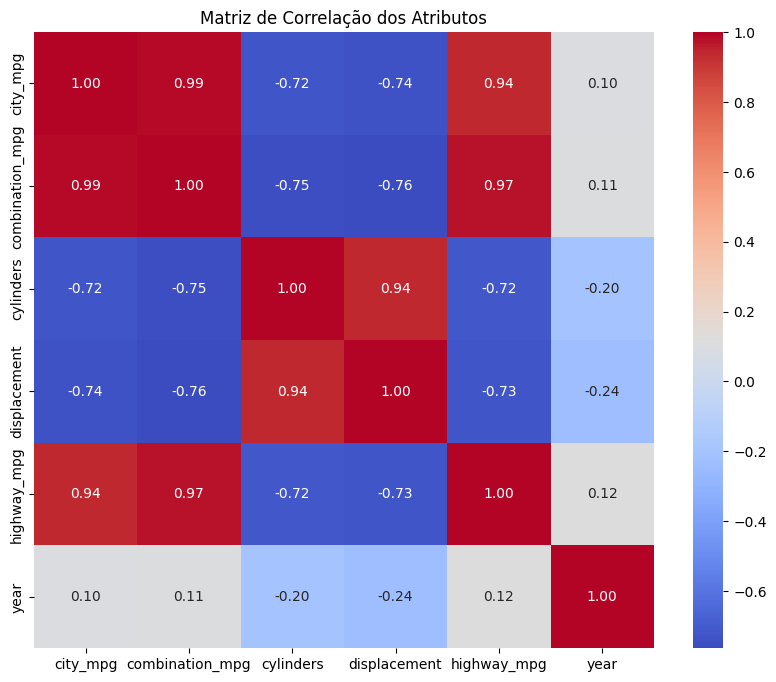

In [5]:
pl.plot_corr_heatmap(original_df,
                     'Matriz de Correlação dos Atributos',
                     'numeric_atributes_correlation')

Olhando para o gráfico acima, percebe-se que há diversos atributos preditores que apresentam alto nível de correlação com a saída _combination mpg_ e entre si. Ambos os atributos _highway mpg_ e _city mpg_ serão descartados do _dataset_ por terem alta correlação entre si e com o valor da saída do modelo, facilitando demais a tarefa dos modelos. Além disso, _displacement_ ou (exclusivo) _cylinders_ será excluído do conjunto de dados por terem alta correlação entre si.

## Pré-processamento dos Dados

Após a etapa de análise dos dados, realizou-se a remoção das instâncias de carros elétricos pois continham muitos atributos faltantes e removeu-se os atributos colineares citados na seção acima. Além disso, realizou-se uma limpeza dos _outliers_ restantes.

In [6]:
# Removendo os atributos colineares
no_colinear_df = pre.drop_atributes(original_df, ['highway_mpg', 'city_mpg', 'displacement'])

# Removendo as instâncias com NaN
no_nan_df = pre.remove_instances_with_nan(no_colinear_df)

no_outliers_df = pre.remove_outliers(no_nan_df, ['combination_mpg'])

Separou-se os atributos preditores `X` e preditos `y` em seguida.

In [7]:
X = no_outliers_df.drop(columns=["combination_mpg"])
y = no_outliers_df["combination_mpg"]

Determinou-se o tamanho do conjunto de teste.

In [8]:
test_proportion = 0.15

Após configurar esse parâmetro, colocou-se ao menos uma instância de cada categoria no _dataset_ de treinamento/validação.

Como não há nenhuma garantia que instância pelo menos uma instância de cada tipo estará na etapa de testes, garantiu-se que pelo menos na parte de treinamento os modelos passariam por todos os tipos de modelos de carros, garantindo preditores treinados com mais completude.

In [9]:
train_indices = set()
categorical_features = X.select_dtypes(include=['object', 'bool']).columns
for feature in categorical_features:
    unique_values = X[feature].unique()
    for value in unique_values:
        index = X[X[feature] == value].index[0]
        train_indices.add(index)

train_indices = list(train_indices)
X_train_mandatory = X.loc[train_indices]
y_train_mandatory = y.loc[train_indices]

X = X.drop(train_indices)
y = y.drop(train_indices)

## Divisão de Dados e _Spot-checking_ de Algoritmos Preditores

Separou-se o conjunto de teste do conjunto de treinamento/validação antes de começar qualquer treinamento ou _spot-checking_ de modelos.

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_proportion)

Com essa separação, aplicou-se o treinamento e validação dos diversos modelos com a estratégia de _k-fold cross-validation_. Todos os modelos escolhidos abaixo foram configurados com os seus hiperparâmetros padrões. A normalização e a codificação dos dados é feita através do método `ColumnTransformer()` do _scikit learn_. Isso garante que, como são aplicadas a normalização por _z-score_ e a codificação _one-hot_ após a separação de teste e treinamento/validação, que não há vazamento de dados no processo. Nesta etapa, há a coleta dos dados necessários para comparar os modelos listados logo em seguida. Esses dados serão mostrados na próxima seção.

In [12]:
# Nomeação de todos os modelos a serem testados
methods = [
    "knn",
    "random_forest",
    "linear_regression",
    "neural_networks",
    "svm",
]

# Variáveis utilizadas para a análise de resultados posteriormente
metrics = {}
predictions = {}

# Variáveis de controle para ajustar o número de iterações que calculam o desempenho e aumentam a reprodutibilidade dessa sequência de códigos
kfolds = 10

for method in methods:
    model_metrics, model_predictions = sc.train(kfolds, False, X_train, y_train, X_train_mandatory, y_train_mandatory, method)
    metrics[method] = model_metrics
    predictions[method] = model_predictions
    print(f'Média para o modelo {method}: {np.average(metrics[method])}\n')

predictions

Média para o modelo knn: 6.534782608695652

Média para o modelo random_forest: 0.8763700075273588

Média para o modelo linear_regression: 0.13890586462856358

Média para o modelo neural_networks: 0.165272433978146

Média para o modelo svm: 2.994050107441972



{'knn': array([27, 18, 18, 17, 18, 21, 20, 19, 19, 22, 21, 19, 28, 20, 22, 25, 19,
        34, 25, 18, 28, 27, 26]),
 'random_forest': array([29.77, 23.48, 23.38, 17.05, 15.78, 21.06, 19.85, 22.55, 20.25,
        25.59, 22.64, 21.07, 25.47, 21.62, 26.4 , 22.85, 19.02, 32.55,
        27.4 , 20.72, 30.29, 26.67, 27.02]),
 'linear_regression': array([30.0005083 , 23.99965976, 23.99965976, 16.99970639, 14.00001603,
        21.00025313, 18.99980847, 22.00017932, 20.00029516, 25.99988273,
        23.00015489, 21.00043397, 26.0001076 , 21.99982177, 25.99992282,
        21.99988179, 18.99997113, 31.99989137, 27.99973353, 21.00011358,
        30.99961457, 27.00017777, 27.00015763]),
 'neural_networks': array([29.43656467, 24.00881774, 24.00587295, 16.99842459, 13.99538379,
        20.99980752, 18.99042554, 22.08782184, 20.06861561, 26.00151617,
        23.03137788, 21.00372506, 26.00598314, 21.99722187, 26.00231319,
        22.00123628, 18.99836142, 32.06391008, 27.97637576, 21.0516158 ,
      

## Sumarização e Avaliação dos Resultados